In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

# Set the random seed for reproducibility
np.random.seed(0)
# set scale and location matrix and number of samples
location = np.array([0, 0])
scale_matrix = np.array([[1, 0], [0, 1]])
num_samples = 10000

# draw samples (note that a multivariate cauchy is just a multivariate t with degree of freedom 1)
cauchy_variable = sp.stats.multivariate_t(loc = location, shape = scale_matrix, df = 1)
samples = cauchy_variable.rvs(num_samples)

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.net = nn.Sequential(
            # Changed input dimension from dim to dim+1 to account for time embedding
            nn.Linear(dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )

    def forward(self, x, t):
        t = t.reshape(-1, 1)
        x_input = torch.cat([x, t], dim=1)
        return self.net(x_input)

# Diffusion hyperparameters
num_timesteps = 1000
beta = torch.linspace(1e-4, 0.02, num_timesteps)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

samples_tensor = torch.FloatTensor(samples)

# Initialize model and optimizer
model = DiffusionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
batch_size = 128

for epoch in tqdm(range(num_epochs)):
    for i in range(0, num_samples, batch_size):
        batch = samples_tensor[i:i+batch_size]

        t = torch.randint(0, num_timesteps, (batch.size(0),))
        epsilon = torch.randn_like(batch)
        noisy_batch = torch.sqrt(alpha_bar[t]).reshape(-1, 1) * batch + \
                     torch.sqrt(1 - alpha_bar[t]).reshape(-1, 1) * epsilon
        predicted_noise = model(noisy_batch, t/num_timesteps)
        loss = nn.MSELoss()(predicted_noise, epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


@torch.no_grad()
def sample(num_samples=1000):
    x = torch.randn(num_samples, 2)
    for t in reversed(range(num_timesteps)):
        t_tensor = torch.ones(num_samples) * t
        predicted_noise = model(x, t_tensor/num_timesteps)
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = 1/torch.sqrt(alpha[t]) * (x - beta[t]/torch.sqrt(1-alpha_bar[t]) * predicted_noise) + \
            torch.sqrt(beta[t]) * noise

    return x


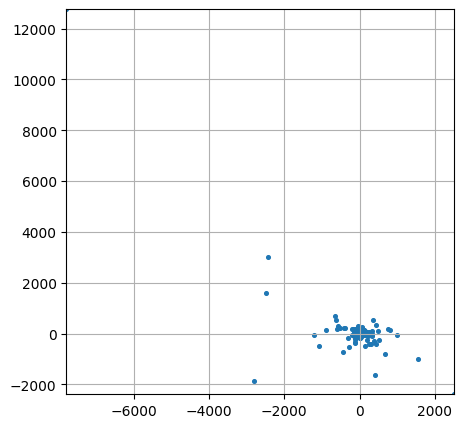

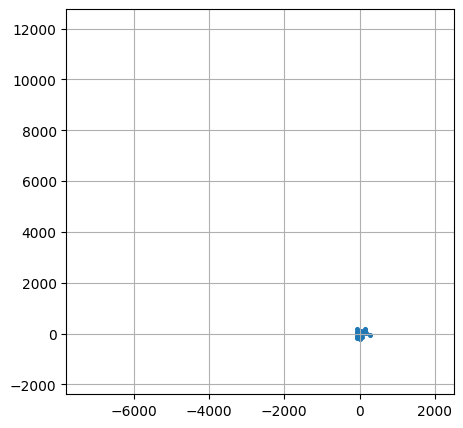

In [ ]:
np.random.seed(100)
# Generate samples using the trained diffusion model
generated_samples = sample().numpy()

# Calculate limits for consistent axes
min_x = min(np.min(samples[:, 0]), np.min(generated_samples[:, 0]))
max_x = max(np.max(samples[:, 0]), np.max(generated_samples[:, 0]))
min_y = min(np.min(samples[:, 1]), np.min(generated_samples[:, 1]))
max_y = max(np.max(samples[:, 1]), np.max(generated_samples[:, 1]))


# Create the scatter plots with consistent axes
plt.figure(figsize=(5, 5))
plt.scatter(samples[:, 0], samples[:, 1], s=7)
plt.grid(True)
plt.xlim(min_x, max_x)  # Set x-axis limits
plt.ylim(min_y, max_y)  # Set y-axis limits
plt.savefig('original_samples_diffusion_standard.png')

plt.figure(figsize=(5, 5))
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=7)
plt.grid(True)
plt.xlim(min_x, max_x)  # Set x-axis limits
plt.ylim(min_y, max_y)  # Set y-axis limits
plt.savefig('diffusion_generated_samples.png')

plt.show()
